# Advanced Active Learning for Regression Tasks

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-activeml/scikit-activeml.github.io/blob/gh-pages/latest/generated/tutorials_colab//07_pool_advanced_regression.ipynb)

In [ ]:
#!pip install scikit-activeml[opt] torch torchvision xgboost

This tutorial demonstrates how to perform pool-based active learning for regression and compare query strategies using two model families:
- a multilayer perceptron (MLP) trained via [skorch](https://github.com/skorch-dev/skorch) (`torch` under the hood),
- a tree-boosting regressor from [xgboost](https://github.com/dmlc/xgboost),
- a random forest regressor from [sklearn](https://github.com/scikit-learn/scikit-learn).

In [2]:
# Comment in for speed up, if you have cuML installed.
# %load_ext cuml.accel
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import warnings

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch.toy import MLPModule
from skactiveml.pool import (
    RandomSampling,
    GreedySamplingTarget,
    SubSamplingWrapper,
)
from skactiveml.regressor import SkorchRegressor, SklearnRegressor
from skactiveml.utils import MISSING_LABEL, call_func
from skorch.callbacks import LRScheduler
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from xgboost import XGBRegressor

CACHE_PATH = ".cache"
os.makedirs(CACHE_PATH, exist_ok=True)
mlp.rcParams["figure.facecolor"] = "white"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
warnings.filterwarnings("ignore")

cuML: Accelerator installed.


## Load Dataset
We use our the `fetch_openml` function from `sklearn.datasets` to load the `superconduct` dataset from [OpenML](https://www.openml.org/). The dataset contains information about superconductors, for which the critical temperature as a continuous target is to predicted.

In [3]:
# Load and cache dataset.
X_full, y_full = fetch_openml(
    data_id=43174, return_X_y=True, data_home=CACHE_PATH
)
X_full = X_full.values
y_full = y_full.values
n_features = X_full.shape[1]

# Create 80-20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2
)

# Standardize numerical features.
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Create Regression Models

We create a dictionary of functions that can be used to create the regression models with varying seeds.

In [4]:
# Setup dictionary of functions for creating regression models.
regressor_dict = {}

# Create random forest regressor.
regressor_dict["RF"] = lambda seed: SklearnRegressor(
    RandomForestRegressor(random_state=seed), random_state=seed
)

# Add gradient-boosted decision tree.
regressor_dict["XGB"] = lambda seed: SklearnRegressor(
    XGBRegressor(device=DEVICE, random_state=seed), random_state=seed
)

regressor_dict["MLP"] = lambda seed: SkorchRegressor(
    module=MLPModule,
    criterion=nn.HuberLoss,
    neural_net_param_dict={
        # Module-related parameters.
        "module__input_units": n_features,
        "module__output_units": 1,
        "module__hidden_units": 256,
        "module__num_hidden": 2,
        "module__dropout": 0.1,
        # Optimizer-related parameters.
        "max_epochs": 100,
        "batch_size": 128,
        "optimizer": torch.optim.RAdam,
        "optimizer__lr": 1e-2,
        "callbacks": [
            ("lr_scheduler", LRScheduler(policy=CosineAnnealingLR, T_max=100))
        ],
        # General parameters.
        "verbose": 0,
        "device": DEVICE,
        "train_split": False,
        "iterator_train__shuffle": True,
        "torch_load_kwargs": {"weights_only": True},
    },
    sample_dtype=np.float32,
    missing_label=MISSING_LABEL,
    random_state=seed,
)

## Create Query Strategies
For simplicity, we only test two query strategies, of which `GreedySamplingI` is a dedicated strategy for regression tasks. If other strategies are to be included, we refer to our [overview of query strategies](https://scikit-activeml.github.io/latest/generated/strategy_overview.html).

In [5]:
query_strategy_dict = {
    "RandomSampling": lambda seed: RandomSampling(random_state=seed),
    "GreedySamplingI": lambda seed: GreedySamplingTarget(
        method="GSi", random_state=seed
    ),
}

## Perform Active Learning Cycle
Each active learning expirment starts with zero labels and covers 30 cycles with an acquisition batch size of 128.

In [6]:
n_reps = 3
n_cycles = 30
query_batch_size = 128
n_sub_set = 1000

results = {}

for reg_name in regressor_dict:
    print(reg_name)
    for qs_name in query_strategy_dict:
        r2_scores = np.full((n_reps, n_cycles), np.nan)
        for i_rep in range(n_reps):
            y = np.full_like(y_train, fill_value=MISSING_LABEL)

            reg = regressor_dict[reg_name](i_rep)
            qs = SubSamplingWrapper(
                query_strategy_dict[qs_name](i_rep),
                max_candidates=n_sub_set,
                exclude_non_subsample=True,
                random_state=i_rep,
            )
            reg.fit(X_train, y)

            for c in tqdm(
                range(n_cycles), desc=f"Repeat {i_rep + 1} with {qs_name}"
            ):
                query_idx = call_func(
                    qs.query,
                    X=X_train,
                    y=y,
                    batch_size=query_batch_size,
                    reg=reg,
                    fit_reg=False,
                )
                y[query_idx] = y_train[query_idx]
                reg.fit(X_train, y)
                score = reg.score(X_test, y_test)
                r2_scores[i_rep, c] = score

        results[f"{reg_name}-{qs_name}"] = r2_scores

RF


Repeat 3 with GreedySamplingI: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


XGB


Repeat 3 with GreedySamplingI: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


MLP


Repeat 3 with GreedySamplingI: 100%|██████████| 30/30 [01:17<00:00,  2.58s/it]


## Visualize Results
In the following, we plot the obtained learning curve of the R2 scores including the area under learning curve (AULC) score per regression model and query strategy.

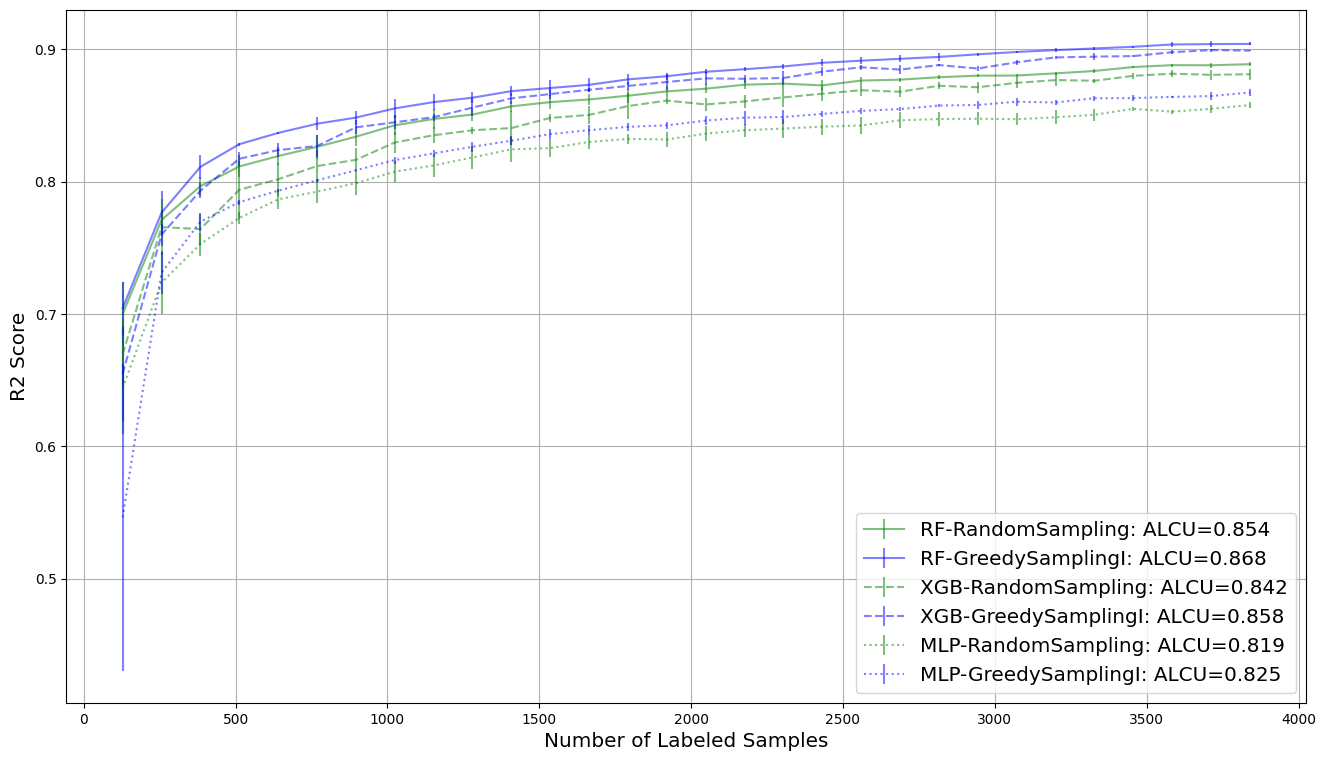

In [7]:
plt.figure(figsize=(16, 9))
for reg_name, ls in zip(regressor_dict, ["-", "--", ":"]):
    for qs_name, c in zip(query_strategy_dict, ["g", "b"]):
        key = qs_name
        result = results[f"{reg_name}-{qs_name}"]
        reshaped_result = result.reshape((-1, n_cycles))
        errorbar_mean = np.mean(reshaped_result, axis=0)
        errorbar_std = np.std(reshaped_result, axis=0)
        plt.errorbar(
            np.arange(1, n_cycles + 1) * query_batch_size,
            errorbar_mean,
            errorbar_std,
            label=f"{reg_name}-{qs_name}: ALCU={np.mean(errorbar_mean):.3f}",
            alpha=0.5,
            color=c,
            linestyle=ls,
        )
plt.grid()
plt.legend(loc="lower right", fontsize="x-large")
plt.xlabel("Number of Labeled Samples", fontsize="x-large")
plt.ylabel("R2 Score", fontsize="x-large")
plt.show()